## Bible-1_06_Ensemble
Please visit below links, Ensemble theories and Implementation are explained.

## English


*   Theory : https://wikidocs.net/165452 and https://wikidocs.net/165453 and https://wikidocs.net/165454 and https://wikidocs.net/165454
*   Implementation : https://wikidocs.net/165473 and https://wikidocs.net/165474  and https://wikidocs.net/165475


## 한글



*   이론 : https://wikidocs.net/164322 and https://wikidocs.net/164645 and https://wikidocs.net/164307 and https://wikidocs.net/164356
*   구현 : https://wikidocs.net/165167 and https://wikidocs.net/164740 and https://wikidocs.net/165000



You can compare it with "06_21_bagging_TF2_MNIST_subclassing_one_model_case_1.py".

Below part is same as baseline code.

11501568/11490434 [==============================] - 0s 0us/step
[5 0 4 1 9 2 1 3 1 4]
(60000, 28, 28)


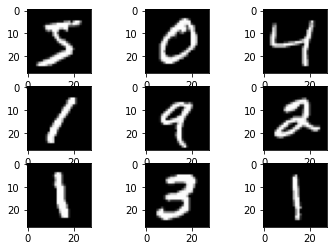

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras import Model, Sequential

from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras import Input

import numpy as np

# Hyper-parameters 
input_size = 784 # 28x28
hidden_size = 256 
num_classes = 10
EPOCHS = 5
batch_size = 100
learning_rate = 0.001

# print(tf.__version__)
## MNIST Dataset #########################################################
mnist = tf.keras.datasets.mnist
# class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
##########################################################################

## Fashion MNIST Dataset #################################################
# mnist = tf.keras.datasets.fashion_mnist
# class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
##########################################################################
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()    

# Change data type as float. If it is unt type, it might cause error 
X_train, X_test = X_train / 255.0, X_test / 255.0

print(Y_train[0:10])
print(X_train.shape)

# in the case of Keras or TF2, type shall be [image_size, image_size, 1]
# if it is RGB type, type shall be [image_size, image_size, 3]
# For MNIST or Fashion MNIST, it need to reshape
X_train_new_axis = np.expand_dims(X_train, axis=-1)
X_test_new_axis = np.expand_dims(X_test, axis=-1)
    
Y_train = to_categorical(Y_train, 10)
Y_test = to_categorical(Y_test, 10)    
    
# 입력된 buffer_size만큼 data를 채우고 무작위로 sampling하여 새로운 data로 바꿉니다.
# 완벽한 셔플링을 위해서는 데이터 세트의 전체 크기보다 크거나 같은 버퍼 크기가 필요합니다.
# 만약 작은 데이터수보다 작은 buffer_size를 사용할경우,
# 처음에 설정된 buffer_size만큼의 data안에서 임의의 셔플링이 발생합니다.
shuffle_size = 100000

train_ds = tf.data.Dataset.from_tensor_slices(
    (X_train_new_axis, Y_train)).shuffle(shuffle_size).batch(batch_size)
test_ds  = tf.data.Dataset.from_tensor_slices((X_test_new_axis, Y_test)).batch(batch_size)

# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
    # if you want to invert color, you can use 'gray_r'. this can be used only for MNIST, Fashion MNIST not cifar10
    # pyplot.imshow(trainX[i], cmap=pyplot.get_cmap('gray_r'))
    
# show the figure
plt.show()

class MNISTModel(tf.keras.Model):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.conv1 = Conv2D(filters=64, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu)
        self.pool1 = MaxPool2D(padding='SAME')
        self.conv2 = Conv2D(filters=128, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu)
        self.pool2 = MaxPool2D(padding='SAME')
        self.pool3_flat = Flatten()
        self.dense4 = Dense(units=128, activation=tf.nn.relu)
        self.drop4 = Dropout(rate=0.4)
        self.dense5 = Dense(10, activation='softmax')
    def call(self, inputs, training=False):
        net = self.conv1(inputs)
        net = self.pool1(net)
        net = self.conv2(net)
        net = self.pool2(net)
        net = self.pool3_flat(net)
        net = self.dense4(net)
        net = self.drop4(net)
        net = self.dense5(net)
        return net

It can be implemented very easily by changing the code part below.

In [2]:
model_1 = MNISTModel()
model_2 = MNISTModel()
model_3 = MNISTModel()

models = [model_1, model_2, model_3]
num_models = len(models)

Other parts are same as baseline code.

In [3]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)


def loss_fn(model, images, labels):
    logits = model(images, training=True)
    loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(
        y_pred=logits, y_true=labels, from_logits=True))    
    return loss   

def grad(model, images, labels):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, images, labels)
    return tape.gradient(loss, model.variables)

def evaluate(models, images, labels):
    predictions = np.zeros_like(labels)
    for model in models:
        logits = model(images, training=False)
        predictions += logits
    correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

checkpoints = []
for m in range(num_models):
    checkpoints.append(tf.train.Checkpoint(cnn=models[m]))

def train_step(model, images, labels):
    gradients = grad(model, images, labels)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

from tqdm import tqdm, tqdm_notebook, trange

for epoch in range(EPOCHS):

    with tqdm_notebook(total=len(train_ds), desc=f"Train Epoch {epoch+1}") as pbar:    
        train_losses = []
        train_accuracies = []
        
        for images, labels in train_ds:
            for model in models:
                train_step(model, images, labels)
            
                loss_val = loss_fn(model, images, labels)
                train_losses.append(loss_val / num_models)
            
            acc = 100 * evaluate(models, images, labels)

            train_accuracies.append(acc)
            
            pbar.update(1)
            pbar.set_postfix_str(f"Loss: {loss_val:.4f} ({np.mean(train_losses):.4f}) Acc: {acc:.3f} ({np.mean(train_accuracies):.3f})")

    with tqdm_notebook(total=len(test_ds), desc=f"Test_ Epoch {epoch+1}") as pbar:    
        test_losses = []
        test_accuracies = []
        for test_images, test_labels in test_ds:
            for model in models:
                loss_val = loss_fn(model, test_images, test_labels)

                test_losses.append(loss_val)
            acc = 100 * evaluate(models, test_images, test_labels)
            
            test_accuracies.append(acc)

            pbar.update(1)
            pbar.set_postfix_str(f"Loss: {loss_val:.4f} ({np.mean(test_losses):.4f}) Acc: {acc:.3f} ({np.mean(test_accuracies):.3f})")
            


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Train Epoch 1:   0%|          | 0/600 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Test_ Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch 2:   0%|          | 0/600 [00:00<?, ?it/s]

Test_ Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch 3:   0%|          | 0/600 [00:00<?, ?it/s]

Test_ Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch 4:   0%|          | 0/600 [00:00<?, ?it/s]

Test_ Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch 5:   0%|          | 0/600 [00:00<?, ?it/s]

Test_ Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]